In [1]:
import os

os.environ['KERAS_BACKEND'] = 'jax'

os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'false'
os.environ['XLA_PYTHON_CLIENT_ALLOCATOR']='platform'

In [2]:
!pip install --upgrade -q keras

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 22.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.10.0 requires tensorflow==2.17.0, but you have tensorflow 2.17.1 which is incompatible.


In [3]:
import numpy as np
import tensorflow_datasets as tfds
import tensorflow as tf
import matplotlib.pyplot as plt
import keras
from keras import layers
from keras.applications import EfficientNetV2M

# IMG_SIZE is determined by EfficientNet model choice
IMG_SIZE = 224
BATCH_SIZE = 32

## Mixed Precision Computation for lower memory usage and higher training speed

In [4]:
# using these two bad boys can increase the training step by over 200% in Keras3 + JAX + training loop from scratch
keras.config.set_dtype_policy("mixed_float16")
keras.mixed_precision.set_global_policy("mixed_float16")

In [5]:
keras.utils.set_random_seed(0)

In [6]:
dataset_name = "stanford_dogs"
(ds_train, ds_test), ds_info = tfds.load(
    dataset_name, split=["train", "test"], with_info=True, as_supervised=True
)
NUM_CLASSES = ds_info.features["label"].num_classes

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/12000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/stanford_dogs/incomplete.Y0CQ65_0.2.0/stanford_dogs-train.tfrecord*...:   …

Generating test examples...:   0%|          | 0/8580 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/stanford_dogs/incomplete.Y0CQ65_0.2.0/stanford_dogs-test.tfrecord*...:   0…

Dataset stanford_dogs downloaded and prepared to /root/tensorflow_datasets/stanford_dogs/0.2.0. Subsequent calls will reuse this data.


In [7]:
size = (IMG_SIZE, IMG_SIZE)
ds_train = ds_train.map(lambda image, label: (tf.image.resize(image, size), label))
ds_test = ds_test.map(lambda image, label: (tf.image.resize(image, size), label))

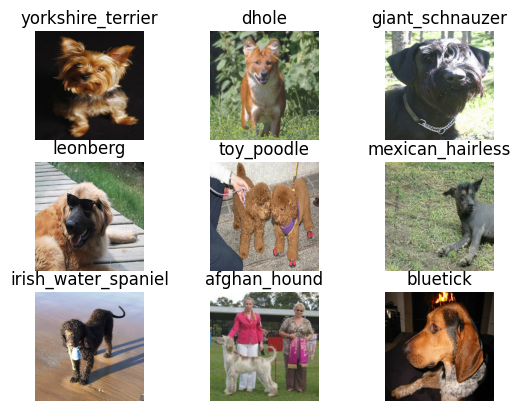

In [8]:
def format_label(label):
    string_label = label_info.int2str(label)
    return string_label.split("-")[1]


label_info = ds_info.features["label"]
for i, (image, label) in enumerate(ds_train.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image.numpy().astype("uint8"))
    plt.title("{}".format(format_label(label)))
    plt.axis("off")

In [9]:
img_augmentation_layers = [
    layers.RandomRotation(factor=0.15),
    layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
    layers.RandomFlip(),
    layers.RandomContrast(factor=0.1),
]


def img_augmentation(images):
    for layer in img_augmentation_layers:
        images = layer(images)
    return images

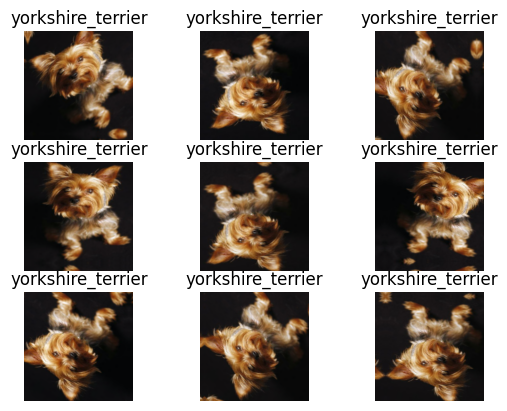

In [10]:
for image, label in ds_train.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        aug_img = img_augmentation(np.expand_dims(image.numpy(), axis=0))
        aug_img = np.array(aug_img)
        plt.imshow(aug_img[0].astype("uint8"))
        plt.title("{}".format(format_label(label)))
        plt.axis("off")

In [11]:
# One-hot / categorical encoding
def input_preprocess_train(image, label):
    image = img_augmentation(image)
    label = tf.one_hot(label, NUM_CLASSES)
    return image, label


def input_preprocess_test(image, label):
    label = tf.one_hot(label, NUM_CLASSES)
    return image, label


ds_train = ds_train.map(input_preprocess_train, num_parallel_calls=tf.data.AUTOTUNE)
ds_train = ds_train.batch(batch_size=BATCH_SIZE, drop_remainder=True)
ds_train = ds_train.prefetch(tf.data.AUTOTUNE)

ds_test = ds_test.map(input_preprocess_test, num_parallel_calls=tf.data.AUTOTUNE)
ds_test = ds_test.batch(batch_size=BATCH_SIZE, drop_remainder=True)

In [12]:
from keras.layers import Flatten, Dense
from keras.models import Sequential

def get_model():
    model = EfficientNetV2M(
    include_top=False,
    weights='imagenet',
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    )

    model.trainable = False


    classifier = Sequential([model, Flatten(), Dense(NUM_CLASSES, activation = 'softmax')])
    classifier.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

    return classifier

In [13]:
# Instantiate a loss function.
loss_fn = keras.losses.CategoricalCrossentropy(from_logits=True)

# Instantiate an optimizer.
optimizer = keras.optimizers.Adam(learning_rate = 0.001)

In [14]:
def compute_loss_and_updates(
    trainable_variables, non_trainable_variables, metric_variables, x, y
):
    y_pred, non_trainable_variables = model.stateless_call(
        trainable_variables, non_trainable_variables, x
    )
    loss = loss_fn(y, y_pred)
    metric_variables = train_acc_metric.stateless_update_state(
        metric_variables, y, y_pred
    )
    return loss, (non_trainable_variables, metric_variables)

In [15]:
# Prepare the metrics.
train_acc_metric = keras.metrics.CategoricalAccuracy()
val_acc_metric = keras.metrics.CategoricalAccuracy()

In [16]:
import jax

In [17]:
grad_fn = jax.value_and_grad(compute_loss_and_updates, has_aux=True)

In [18]:
@jax.jit
def train_step(state, data):
    (
        trainable_variables,
        non_trainable_variables,
        optimizer_variables,
        metric_variables,
    ) = state
    x, y = data
    (loss, (non_trainable_variables, metric_variables)), grads = grad_fn(
        trainable_variables, non_trainable_variables, metric_variables, x, y
    )
    trainable_variables, optimizer_variables = optimizer.stateless_apply(
        optimizer_variables, grads, trainable_variables
    )
    # Return updated state
    return loss, (
        trainable_variables,
        non_trainable_variables,
        optimizer_variables,
        metric_variables,
    )

In [19]:
@jax.jit
def eval_step(state, data):
    trainable_variables, non_trainable_variables, metric_variables = state
    x, y = data
    y_pred, non_trainable_variables = model.stateless_call(
        trainable_variables, non_trainable_variables, x
    )
    loss = loss_fn(y, y_pred)
    metric_variables = val_acc_metric.stateless_update_state(
        metric_variables, y, y_pred
    )
    return loss, (
        trainable_variables,
        non_trainable_variables,
        metric_variables,
    )

In [20]:
model = get_model()

214201816/214201816 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [21]:
model.summary(show_trainable = True)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Layer (type)                        ┃ Output Shape                 ┃       Param # ┃ Traina… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ efficientnetv2-m (Functional)       │ (None, 7, 7, 1280)           │    53,150,388 │    N    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ flatten (Flatten)                   │ (None, 62720)                │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ dense (Dense)                       │ (None, 120)                  │     7,526,520 │    Y    │
└─────────────────────────────────────┴──────────────────────────────┴───────────────┴─────────┘

 Total params: 60,676,908 (231.46 MB)

 Trainable params: 7,526,520 (28.71 MB)

 Non-trainable params: 53,150,388 (202.75 MB)

In [22]:
# Build optimizer variables.
optimizer.build(model.trainable_variables)

# trainable_variables = model.trainable_variables
# non_trainable_variables = model.non_trainable_variables
# optimizer_variables = optimizer.variables
# metric_variables = train_acc_metric.variables

state = (
    model.trainable_variables,
    model.non_trainable_variables,
    optimizer.variables,
    train_acc_metric.variables,
)

In [23]:
from time import time as t
import jax.numpy as jnp

epochs = 50

for epoch in range(epochs):

    print('===================================================================================')
    print(f'Epoch : {epoch+1}')
    # Training loop
    for step, data in enumerate(ds_train):
        
        data = (jnp.array(data[0].numpy(), dtype = jnp.float16), jnp.array(data[1].numpy(), dtype=jnp.float16))
        
        a = t()
        loss, state = train_step(state, data)
        b = t()
        
        # Log every 10 batches.
        if step % 20 == 0:
            metric_variables = state[3]
            for variable, value in zip(train_acc_metric.variables, metric_variables):
                variable.assign(value)
            print(f"Training accuracy: {train_acc_metric.result():.4f} ---- Time : {(b-a):.4f}s")


Epoch : 1
Training accuracy: 0.0000 ---- Time : 12.3794s
Training accuracy: 0.0402 ---- Time : 0.1537s
Training accuracy: 0.0419 ---- Time : 0.1570s
Training accuracy: 0.0482 ---- Time : 0.1630s
Training accuracy: 0.0455 ---- Time : 0.1668s
Training accuracy: 0.0439 ---- Time : 0.1638s
Training accuracy: 0.0424 ---- Time : 0.1605s
Training accuracy: 0.0445 ---- Time : 0.1498s
Training accuracy: 0.0458 ---- Time : 0.1531s
Training accuracy: 0.0475 ---- Time : 0.1609s
Training accuracy: 0.0491 ---- Time : 0.1564s
Training accuracy: 0.0506 ---- Time : 0.1582s
Training accuracy: 0.0508 ---- Time : 0.1522s
Training accuracy: 0.0520 ---- Time : 0.1595s
Training accuracy: 0.0530 ---- Time : 0.1468s
Training accuracy: 0.0551 ---- Time : 0.1899s
Training accuracy: 0.0565 ---- Time : 0.1475s
Training accuracy: 0.0566 ---- Time : 0.1646s
Training accuracy: 0.0575 ---- Time : 0.1545s
Epoch : 2
Training accuracy: 0.0590 ---- Time : 0.1614s
Training accuracy: 0.0619 ---- Time : 0.1646s
Training accu

In [24]:
for layer in model.layers:
    layer.trainable = True

model.summary(show_trainable = True)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Layer (type)                        ┃ Output Shape                 ┃       Param # ┃ Traina… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ efficientnetv2-m (Functional)       │ (None, 7, 7, 1280)           │    53,150,388 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ flatten (Flatten)                   │ (None, 62720)                │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ dense (Dense)                       │ (None, 120)                  │     7,526,520 │    Y    │
└─────────────────────────────────────┴──────────────────────────────┴───────────────┴─────────┘

 Total params: 60,676,908 (231.46 MB)

 Trainable params: 60,384,876 (230.35 MB)

 Non-trainable params: 292,032 (1.11 MB)

In [25]:
# Instantiate an optimizer.
optimizer = keras.optimizers.Adam(learning_rate = 0.00005)
# Build optimizer variables.
optimizer.build(model.trainable_variables)

# trainable_variables = model.trainable_variables
# non_trainable_variables = model.non_trainable_variables
# optimizer_variables = optimizer.variables
# metric_variables = train_acc_metric.variables

state = (
    model.trainable_variables,
    model.non_trainable_variables,
    optimizer.variables,
    train_acc_metric.variables,
)

In [26]:
from time import time as t


epochs = 20

for epoch in range(epochs):

    print('===================================================================================')
    print(f'Epoch : {epoch+1}')
    # Training loop
    for step, data in enumerate(ds_train):

        data = (jnp.array(data[0].numpy(), dtype = jnp.float16), jnp.array(data[1].numpy(), dtype=jnp.float16))
        
        a = t()
        loss, state = train_step(state, data)
        b = t()
        
        if step % 20 == 0:
            metric_variables = state[3]
            for variable, value in zip(train_acc_metric.variables, metric_variables):
                variable.assign(value)
            print(f"Training accuracy: {train_acc_metric.result():.4f} ---- Time : {(b-a):.4f}s")

Epoch : 1
Training accuracy: 0.1362 ---- Time : 48.0397s
Training accuracy: 0.1361 ---- Time : 0.5578s
Training accuracy: 0.1361 ---- Time : 0.5324s
Training accuracy: 0.1362 ---- Time : 0.5210s
Training accuracy: 0.1365 ---- Time : 0.5422s
Training accuracy: 0.1367 ---- Time : 0.5636s
Training accuracy: 0.1370 ---- Time : 0.5485s
Training accuracy: 0.1373 ---- Time : 0.5438s
Training accuracy: 0.1376 ---- Time : 0.5395s
Training accuracy: 0.1380 ---- Time : 0.5135s
Training accuracy: 0.1383 ---- Time : 0.5305s
Training accuracy: 0.1387 ---- Time : 0.5281s
Training accuracy: 0.1391 ---- Time : 0.5406s
Training accuracy: 0.1394 ---- Time : 0.5270s
Training accuracy: 0.1398 ---- Time : 0.5227s
Training accuracy: 0.1402 ---- Time : 0.5232s
Training accuracy: 0.1406 ---- Time : 0.5349s
Training accuracy: 0.1410 ---- Time : 0.5357s
Training accuracy: 0.1413 ---- Time : 0.5253s
Epoch : 2
Training accuracy: 0.1416 ---- Time : 0.6043s
Training accuracy: 0.1421 ---- Time : 0.5353s
Training accu